##Credit for the prediction model portion of this notebook goes to

https://www.kaggle.com/code/lucasgvazquez/road-to-the-top-part-2-less-is-more

In [ ]:
%pip install kaggle

try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

from fastkaggle import *

try: import timm
except ModuleNotFoundError:
    %pip install "timm>=0.6.2.dev0"
    import timm

%pip install fastai --upgrade
from fastai.vision.all import *

%pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
od.download("https://www.kaggle.com/competitions/noaa-right-whale-recognition/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: robertcscott
Your Kaggle Key: ··········


100%|██████████| 9.12G/9.12G [07:09<00:00, 22.8MB/s]



Extracting archive ./noaa-right-whale-recognition/noaa-right-whale-recognition.zip to ./noaa-right-whale-recognition


User: robertcscott

Key: 104c688dc95522a8cfa3c2fca25eabc8

In [ ]:
comp = 'noaa-right-whale-recognition'
data_dir = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
imgs_dir = untar_dir(data_dir/'imgs.zip', Path('imgs'))

In [ ]:
image_files = get_image_files('imgs')

In [ ]:
if not Path('imgs_480max').exists():
    resize_images(imgs_dir, dest='imgs_480max', max_size=480, progress=progress_bar)

KeyboardInterrupt: ignored

## Data Pipeline

In [ ]:
targs_df = pd.read_csv(data_dir/'train.csv')
targs_df = targs_df[targs_df['Image']!='w_7489.jpg']
items = targs_df['Image']

In [ ]:
def get_image_path(name):
    return Path('imgs_480max')/name
    
def get_label(name):
    return targs_df[targs_df['Image']==name]['whaleID'].item()

In [ ]:
x_pipe = [get_image_path, PILImage.create]
y_pipe = [get_label, Categorize()]

In [ ]:
# make sure at least one of each whale is in training set, then randomly split
must_train_whales = targs_df.groupby('whaleID').first()['Image']
# some magic from [here](https://stackoverflow.com/questions/49823963/get-index-of-one-series-into-another-in-pandas)
must_train_ids = pd.Series(targs_df['Image'].index, index=targs_df['Image']).get(must_train_whales)
must_train_ids = set(must_train_ids)

train_ids, valid_ids = RandomSplitter(seed=42)(items)
print(f"Before: train_ids={len(train_ids)}, valid_ids={len(valid_ids)}")
train_ids = L(set(train_ids).union(must_train_ids))
valid_ids = L(set(valid_ids) - must_train_ids)
print(f"After: train_ids={len(train_ids)}, valid_ids={len(valid_ids)}")
splits = (train_ids, valid_ids)

Before: train_ids=3635, valid_ids=908
After: train_ids=3728, valid_ids=815


In [ ]:
dss = Datasets(items, [x_pipe, y_pipe], splits=splits)

FileNotFoundError: ignored

<Axes: title={'center': 'whale_82548'}>

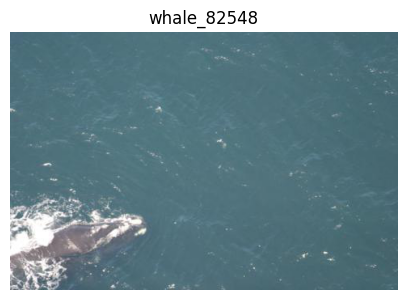

In [ ]:
dss.show(dss[76])

In [ ]:
after_item = [ToTensor(), Resize((320, 480))]
after_batch = [IntToFloatTensor(), *aug_transforms(size=(224, 336))]

dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

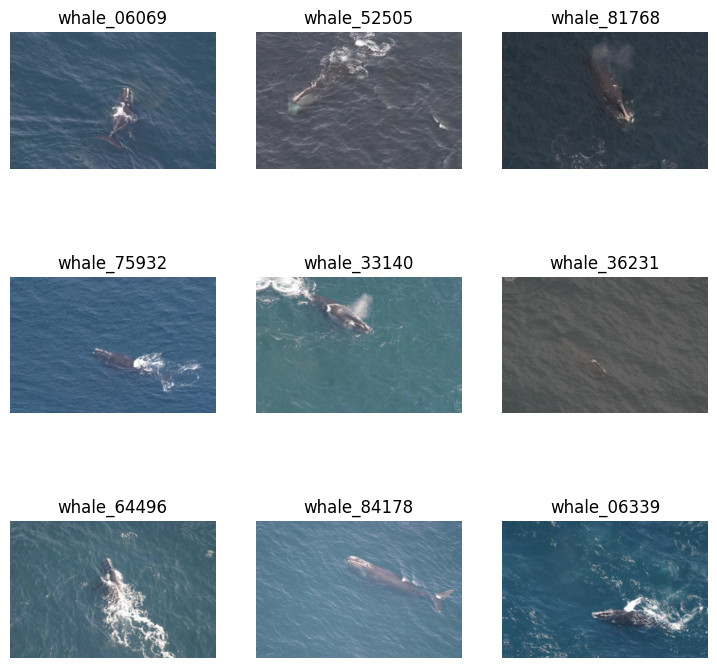

In [ ]:
dls.show_batch()

In [ ]:
metrics = [error_rate]

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=metrics).to_fp16()

/usr/local/lib/python3.9/dist-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This shoul

In [ ]:
learn.fine_tune(10, 0.002)

epoch,train_loss,valid_loss,error_rate,time
0,7.395789,6.311605,0.965644,00:38


epoch,train_loss,valid_loss,error_rate,time
0,6.156538,5.819277,0.947239,00:35
1,5.819339,5.640267,0.932515,00:32
2,5.466120,5.470051,0.911656,00:34
3,5.069932,5.323874,0.900613,00:32
4,4.613562,5.215849,0.880982,00:34
5,4.180920,5.103656,0.868712,00:33
6,3.716518,5.018682,0.857669,00:34


In [ ]:
#This function is passed into the LimeImageExplainer in order to return a numpy array of class probabilities given a numpy input matrix (the image)
def learnerPredict(imgs):
    predictions = [learn.predict(img) for img in imgs]
    to_return = [p[2].numpy() for p in predictions]
    return to_return

In [ ]:
#This function grabs a numpy matrix version of the PIL image stored with element i of dss[]
def getDss(i):
    return np.array(dss[i][0])

In [ ]:
!pip install lime
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

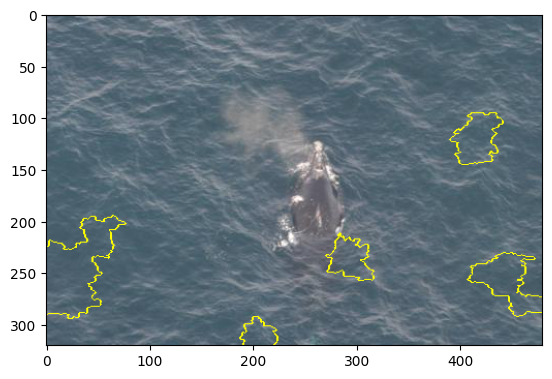

In [ ]:
import skimage

explanationImages = []

#For each of the first 10 images in the set, add the corresponding explanation image to an array
for i in range(10):
    explanation = explainer.explain_instance(getDss(i), learnerPredict)

    labelToExplain = learn.predict(getDss(i))[1].item()
    expImage, expMask = explanation.get_image_and_mask(labelToExplain)

    explanationImages.append(skimage.segmentation.mark_boundaries(expImage, expMask))

plt.imshow(explanationImages[0])